In [41]:
import pandas as pd

processed_df = pd.read_csv('data_processed.csv')
processed_df.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,NaN
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,NaN
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,NaN
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,NaN
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,NaN


### Interval 0으로 채우기

In [42]:
processed_df['TX_INTERVAL'].fillna(0, inplace=True)

/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_99656/3515551195.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['TX_INTERVAL'].fillna(0, inplace=True)


In [43]:
processed_df_drop = processed_df.dropna()

In [44]:
processed_df_drop.head()

,MBR_NO,TX_DTTM,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,2024-06-03 23:30:35,-923000.0,2,0,0,0.0
1,1303,2024-06-04 19:15:51,-920000.0,2,0,0,0.0
2,1349,2024-07-23 16:18:29,-644000.0,2,0,0,0.0
3,1349,2024-06-04 00:30:53,-489190.0,2,0,0,0.0
4,1303,2024-06-30 05:20:10,-13283.0,0,0,0,0.0


In [45]:
from sklearn.preprocessing import StandardScaler

df_copy = processed_df_drop.copy()

scaler = StandardScaler()
df_copy['TX_AMT'] = scaler.fit_transform(df_copy[['TX_AMT']])

df_copy['TX_TIME'] = pd.to_datetime(df_copy['TX_DTTM']).dt.hour + pd.to_datetime(df_copy['TX_DTTM']).dt.minute / 60

In [46]:
cleaned_df = df_copy[['MBR_NO', 'TX_TIME','TX_AMT', 'TX_TYPE', 'BIS_NM', 'REGULAR_YN', 'TX_INTERVAL']].copy()

cleaned_df.head()

,MBR_NO,TX_TIME,TX_AMT,TX_TYPE,BIS_NM,REGULAR_YN,TX_INTERVAL
0,1303,23.500000,-8.849636,2,0,0,0.0
1,1303,19.250000,-8.821235,2,0,0,0.0
2,1349,16.300000,-6.208327,2,0,0,0.0
3,1349,0.500000,-4.742732,2,0,0,0.0
4,1303,5.333333,-0.237293,0,0,0,0.0


In [47]:
print(cleaned_df['REGULAR_YN'].value_counts())


REGULAR_YN
0    2500973
1       2060
Name: count, dtype: int64


### 데이터 불균형 확인

In [48]:
label_percentage = cleaned_df['REGULAR_YN'].value_counts(normalize=True) * 100
print(label_percentage)



REGULAR_YN
0    99.9177
1     0.0823
Name: proportion, dtype: float64


In [49]:
import numpy as np

features = cleaned_df.values
labels = np.array(cleaned_df.pop('REGULAR_YN'))

print(features.shape)
print(labels.shape)

(2503033, 7)
(2503033,)


In [50]:
from sklearn.model_selection import train_test_split


# 훈련/임시 테스트 데이터 나누기
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.5, random_state=42, stratify=labels)

# 임시 테스트 데이터를 테스트/검증으로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"훈련 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}, 테스트 데이터 크기: {X_test.shape}")


훈련 데이터 크기: (1251516, 7), 검증 데이터 크기: (625758, 7), 테스트 데이터 크기: (625759, 7)


In [51]:
from collections import Counter

print(Counter(labels))
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))


Counter({np.int64(0): 2500973, np.int64(1): 2060})
Counter({np.int64(0): 1250486, np.int64(1): 1030})
Counter({np.int64(0): 625243, np.int64(1): 515})
Counter({np.int64(0): 625244, np.int64(1): 515})


### SMOTE

In [53]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.4)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_smote.shape, y_train_smote.shape,Counter(y_train_smote)

((1750680, 7),
 (1750680,),
 Counter({np.int64(0): 1250486, np.int64(1): 500194}))

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(features)

print(x_pca.shape, Counter(y_train_smote))


(2503033, 2) Counter({np.int64(0): 1250486, np.int64(1): 500194})


/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_99656/2601514318.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


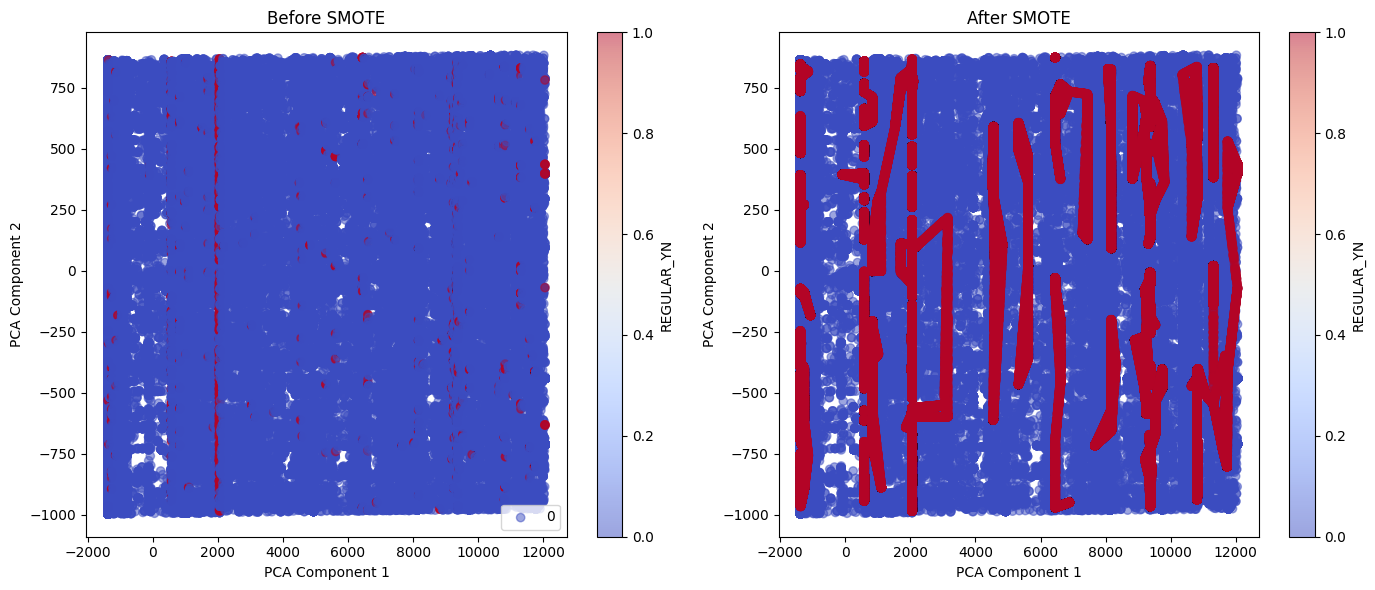

In [55]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA로 2차원으로 변환
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
X_train_smote_2d = pca.transform(X_train_smote)
X_val_2d = pca.transform(X_val)
X_test_2d = pca.transform(X_test)


plt.figure(figsize=(14, 6))



# SMOTE 전
plt.subplot(1, 2, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.5)
plt.title("Before SMOTE")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="REGULAR_YN")
plt.legend(['0', '1'])

# SMOTE 후
plt.subplot(1, 2, 2)
plt.scatter(X_train_smote_2d[:, 0], X_train_smote_2d[:, 1], c=y_train_smote, cmap='coolwarm', alpha=0.5)
plt.title("After SMOTE")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="REGULAR_YN")

plt.tight_layout()
plt.show()


In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

METRICS = tf.keras.metrics.AUC(name='auc')

In [57]:
def make_model():
    model = tf.keras.Sequential([
      Dense(32, activation='relu', input_shape=(X_train_smote.shape[-1],)),
      Dropout(0.2),
      Dense(16, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid'),
      ])

    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
      loss = 'binary_crossentropy', metrics=[METRICS, 'accuracy'])

    return model

In [58]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,        # no of epochs of no improvement          
    mode='max',        #val_auc 가 10 번 연속 증가 안하면 stop           
    restore_best_weights=True)      # epoch 의 best weight 저장

In [59]:
base_model = make_model()
base_model.summary()

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
baseline_history = base_model.fit(X_train_smote, y_train_smote, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

Epoch 1/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7283 - auc: 0.7634 - loss: 4.6332 - val_accuracy: 0.8047 - val_auc: 0.8956 - val_loss: 0.1964
Epoch 2/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8238 - auc: 0.8796 - loss: 0.3222 - val_accuracy: 0.8130 - val_auc: 0.9064 - val_loss: 0.2034
Epoch 3/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8288 - auc: 0.8886 - loss: 0.3155 - val_accuracy: 0.8134 - val_auc: 0.9061 - val_loss: 0.2101
Epoch 4/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8585 - auc: 0.9008 - loss: 0.2743 - val_accuracy: 0.8134 - val_auc: 0.9022 - val_loss: 0.2027
Epoch 5/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8548 - auc: 0.9011 - loss: 0.2817 - val_accuracy: 0.8147 - val_auc: 0.9121 - val_loss: 0.1881
Epoch 6/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8583 - auc: 0.9139 - loss: 0.2641 - val_accuracy: 0.8164 - val_auc: 0.9195 - val_loss: 0.1850
Epoch 7/100
855/855 ━━━━━━━━━━━━━━

In [61]:
baseline_history.history['val_accuracy'][-1]

0.8134473562240601

In [62]:
predictions_baseline  = base_model.predict(X_test)
predictions_baseline.shape

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 4s 219us/step


(625759, 1)

In [63]:
predictions_baseline.shape

(625759, 1)

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def plot_cm(y_test, y_pred_prob, threshold):
    
    y_pred = y_pred_prob > threshold
    
    cm = confusion_matrix(y_test, y_pred)
    
    print("f1 score:", f1_score(y_test, y_pred))
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("Precision", precision_score(y_test, y_pred))
    print("Recall", recall_score(y_test, y_pred))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix (threshold>{:.2f}) '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

f1 score: 0.008908955662809002
Accuracy 0.8168879712477167
Precision 0.004474408987045935
Recall 1.0


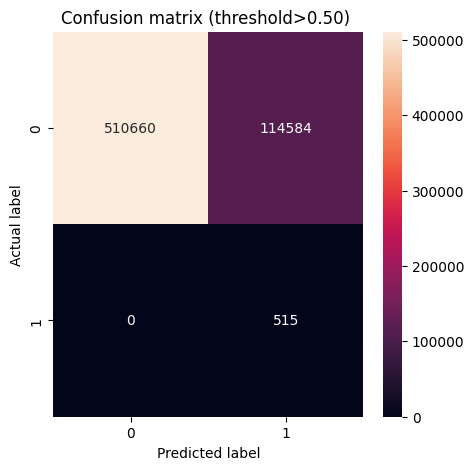

In [65]:
plot_cm(y_test, predictions_baseline, threshold=0.5)

f1 score: 0.008895567761771514
Accuracy 0.8166099089265996
Precision 0.004467655044980178
Recall 1.0


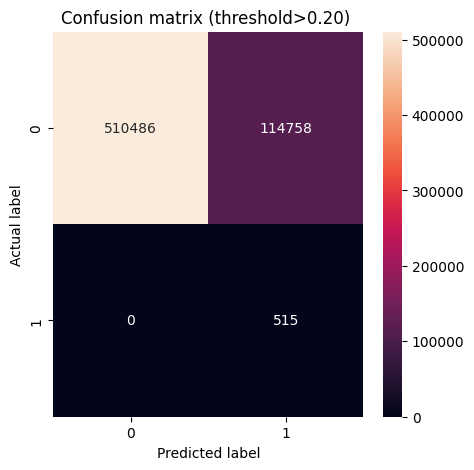

In [66]:
plot_cm(y_test, predictions_baseline, threshold=0.2)

f1 score: 0.008913504391848038
Accuracy 0.816982256747406
Precision 0.004476703755215577
Recall 1.0


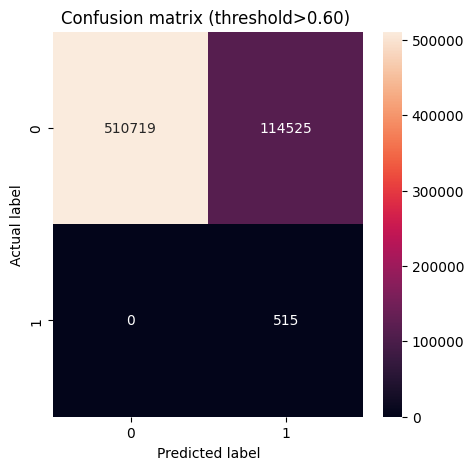

In [71]:
plot_cm(y_test, predictions_baseline, threshold=0.6)

In [72]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential

def make_complex_model():
    model = Sequential([
        # 첫 번째 은닉층
        Dense(128, activation='relu', input_shape=(X_train_smote.shape[-1],)),
        BatchNormalization(),  # 배치 정규화 추가
        Dropout(0.3),          # 드롭아웃 비율 증가
        
        # 두 번째 은닉층
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # 세 번째 은닉층
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # 네 번째 은닉층
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # 출력층
        Dense(1, activation='sigmoid')  # 이진 분류를 위한 시그모이드 활성화
    ])

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # 학습률 감소
        loss='binary_crossentropy', 
        metrics=['AUC', 'accuracy']
    )

    return model


In [73]:
complex_model = make_complex_model()
complex_model.summary()


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,865 (50.25 KB)

 Trainable params: 12,385 (48.38 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - AUC: 0.8900 - accuracy: 0.8344 - loss: 0.4031 - val_AUC: 0.9274 - val_accuracy: 0.8566 - val_loss: 0.2168
Epoch 2/100
 30/855 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.9860 - accuracy: 0.9531 - loss: 0.1306

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9873 - accuracy: 0.9521 - loss: 0.1260 - val_AUC: 0.9403 - val_accuracy: 0.8733 - val_loss: 0.1851
Epoch 3/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9902 - accuracy: 0.9546 - loss: 0.1098 - val_AUC: 0.9976 - val_accuracy: 0.9805 - val_loss: 0.0742
Epoch 4/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9905 - accuracy: 0.9597 - loss: 0.1056 - val_AUC: 0.9978 - val_accuracy: 0.9590 - val_loss: 0.0929
Epoch 5/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9931 - accuracy: 0.9604 - loss: 0.0930 - val_AUC: 0.9998 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 6/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.9973 - accuracy: 0.9802 - loss: 0.0516 - val_AUC: 0.9990 - val_accuracy: 1.0000 - val_loss: 3.9054e-04
Epoch 7/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9950 - accuracy: 0.9701 - loss: 0.0756 - val_AUC: 0.9984 - val_accuracy: 0.9981 - val_loss: 0.0167
Epoch 8/100
855/855 ━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:

EPOCHS = 20
complex_history = complex_model.fit(X_train_smote, y_train_smote, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

In [ ]:
plot_cm(y_test, complex_model.predict(X_test), threshold=0.5)

### Class weight  조정

In [76]:
neg, pos = Counter(y_train_smote).values()
total = neg + pos

In [77]:
neg, pos, total

(1250486, 500194, 1750680)

In [78]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.6999998400621839, 1: 1.7500009996121504}


In [80]:
EPOCHS = 20

weighted_complex_model = make_complex_model()
weighted_complex_model.fit(X_train_smote, y_train_smote, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test),
                             class_weight=class_weight)

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.8953 - accuracy: 0.8238 - loss: 0.3900 - val_AUC: 0.9000 - val_accuracy: 0.8706 - val_loss: 0.2305
Epoch 2/20
 13/855 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - AUC: 0.9762 - accuracy: 0.9156 - loss: 0.1861

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.9849 - accuracy: 0.9430 - loss: 0.1415 - val_AUC: 0.9943 - val_accuracy: 0.8886 - val_loss: 0.2839
Epoch 3/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9949 - accuracy: 0.9683 - loss: 0.0775 - val_AUC: 0.9839 - val_accuracy: 0.9658 - val_loss: 0.1010
Epoch 4/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9887 - accuracy: 0.9527 - loss: 0.1178 - val_AUC: 0.9597 - val_accuracy: 0.6120 - val_loss: 1.0645
Epoch 5/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9937 - accuracy: 0.9649 - loss: 0.0885 - val_AUC: 0.9981 - val_accuracy: 0.9699 - val_loss: 0.0757
Epoch 6/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9946 - accuracy: 0.9665 - loss: 0.0819 - val_AUC: 0.9987 - val_accuracy: 0.9594 - val_loss: 0.0847
Epoch 7/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9979 - accuracy: 0.9798 - loss: 0.0510 - val_AUC: 0.9614 - val_accuracy: 0.8363 - val_loss: 0.8468
Epoch 8/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

loss :  2.4395634682150558e-05
compile_metrics :  1.0

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 5s 273us/step
f1 score: 1.0
Accuracy 1.0
Precision 1.0
Recall 1.0


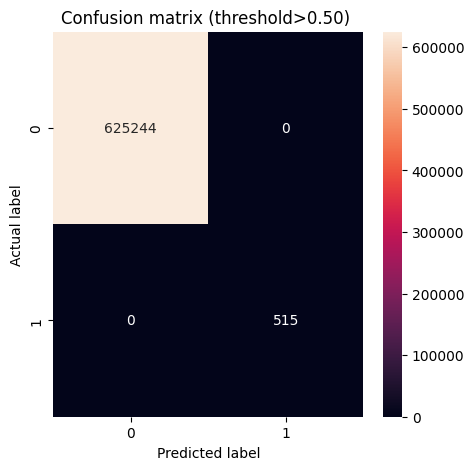

In [81]:
weighted_results = weighted_complex_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_complex_model.metrics_names, weighted_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, weighted_complex_model.predict(X_test), threshold=0.5)

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential

def make_complex_model_beforeSMOTE():
    model = Sequential([
        # 첫 번째 은닉층
        Dense(128, activation='relu', input_shape=(X_train.shape[-1],)),
        BatchNormalization(),  # 배치 정규화 추가
        Dropout(0.3),          # 드롭아웃 비율 증가
        
        # 두 번째 은닉층
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # 세 번째 은닉층
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # 네 번째 은닉층
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # 출력층
        Dense(1, activation='sigmoid')  # 이진 분류를 위한 시그모이드 활성화
    ])

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # 학습률 감소
        loss='binary_crossentropy', 
        metrics=['AUC', 'accuracy']
    )

    return model


In [83]:
EPOCHS = 20

weighted_complex_model_beforeSMOTE = make_complex_model_beforeSMOTE()
weighted_complex_model_beforeSMOTE.fit(X_train, y_train, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test),
                             class_weight=class_weight)

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.5101 - accuracy: 0.8079 - loss: 0.3098 - val_AUC: 0.6554 - val_accuracy: 0.9992 - val_loss: 0.0215
Epoch 2/20
 26/612 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.5371 - accuracy: 0.9993 - loss: 0.0193

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5838 - accuracy: 0.9991 - loss: 0.0169 - val_AUC: 0.8284 - val_accuracy: 0.9992 - val_loss: 0.0082
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.6909 - accuracy: 0.9992 - loss: 0.0108 - val_AUC: 0.7506 - val_accuracy: 0.9992 - val_loss: 0.0067
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6967 - accuracy: 0.9992 - loss: 0.0100 - val_AUC: 0.7214 - val_accuracy: 0.9992 - val_loss: 0.0062
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - AUC: 0.7008 - accuracy: 0.9992 - loss: 0.0094 - val_AUC: 0.6928 - val_accuracy: 0.9992 - val_loss: 0.0060
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7155 - accuracy: 0.9992 - loss: 0.0095 - val_AUC: 0.7235 - val_accuracy: 0.9992 - val_loss: 0.0058
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.7337 - accuracy: 0.9991 - loss: 0.0095 - val_AUC: 0.7104 - val_accuracy: 0.9992 - val_loss: 0.0057
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

loss :  0.004349224269390106
compile_metrics :  0.8851611018180847

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 5s 275us/step
f1 score: 0.003875968992248062
Accuracy 0.9991785975111824
Precision 1.0
Recall 0.001941747572815534


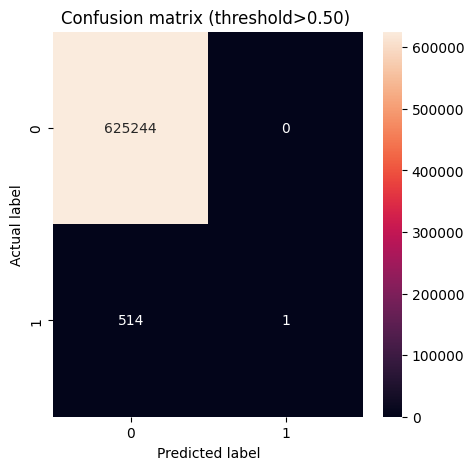

In [84]:
weighted_results = weighted_complex_model_beforeSMOTE.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_complex_model_beforeSMOTE.metrics_names, weighted_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, weighted_complex_model_beforeSMOTE.predict(X_test), threshold=0.5)

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 5s 279us/step
f1 score: 0.06847360912981455
Accuracy 0.998956467266152
Precision 0.12903225806451613
Recall 0.04660194174757282


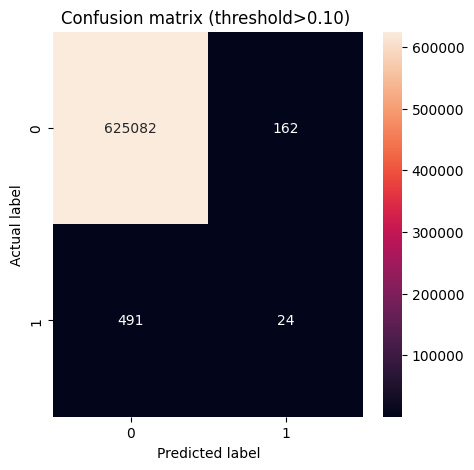

In [85]:
plot_cm(y_test, weighted_complex_model_beforeSMOTE.predict(X_test), threshold=0.1)

In [87]:
weighted_complex_model_beforeCW = make_complex_model()
weighted_complex_model_beforeCW.fit(X_train_smote, y_train_smote, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

Epoch 1/20


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


855/855 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.9128 - accuracy: 0.8560 - loss: 0.3654 - val_AUC: 0.9805 - val_accuracy: 0.9370 - val_loss: 0.1209
Epoch 2/20
 19/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9897 - accuracy: 0.9551 - loss: 0.1150

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9793 - accuracy: 0.9317 - loss: 0.1627 - val_AUC: 0.9858 - val_accuracy: 0.9630 - val_loss: 0.0812
Epoch 3/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9930 - accuracy: 0.9653 - loss: 0.0913 - val_AUC: 0.9926 - val_accuracy: 0.9646 - val_loss: 0.0816
Epoch 4/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9911 - accuracy: 0.9658 - loss: 0.0982 - val_AUC: 0.9985 - val_accuracy: 0.8845 - val_loss: 0.1911
Epoch 5/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.9960 - accuracy: 0.9721 - loss: 0.0693 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 6/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.9965 - accuracy: 0.9755 - loss: 0.0623 - val_AUC: 0.9973 - val_accuracy: 0.9721 - val_loss: 0.0641
Epoch 7/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9969 - accuracy: 0.9760 - loss: 0.0613 - val_AUC: 0.9999 - val_accuracy: 0.9995 - val_loss: 0.0038
Epoch 8/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

loss :  1.884859898382274e-06
compile_metrics :  1.0

19555/19555 ━━━━━━━━━━━━━━━━━━━━ 6s 286us/step
f1 score: 1.0
Accuracy 1.0
Precision 1.0
Recall 1.0


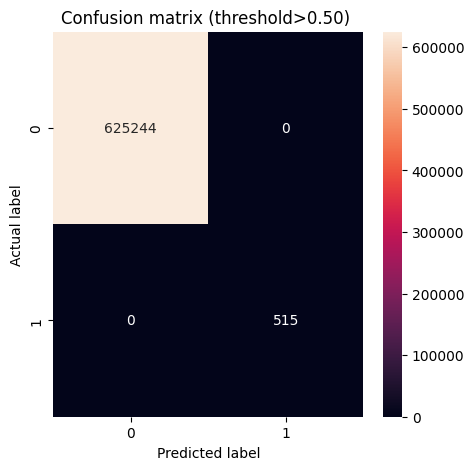

In [88]:
weighted_results = weighted_complex_model_beforeCW.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_complex_model_beforeCW.metrics_names, weighted_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, weighted_complex_model_beforeCW.predict(X_test), threshold=0.5)


In [89]:
from sklearn.model_selection import StratifiedKFold

# 교차검증 수행
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for train_idx, val_idx in skf.split(X_train_, y_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    model = make_complex_model()
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    
    y_pred = model.predict(X_val_fold)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, y_pred_binary)
    f1_scores.append(f1)

print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 3s 315us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7822/7822 ━━━━━━━━━━━━━━━━━━━━ 3s 330us/step
F1 Scores for each fold: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.009302325581395349), np.float64(0.04416403785488959)]
Mean F1 Score: 0.010693272687256988


In [90]:
from sklearn.model_selection import StratifiedKFold

# 교차검증 수행
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for train_idx, val_idx in skf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_idx], X_train_smote[val_idx]
    y_train_fold, y_val_fold = y_train_smote[train_idx], y_train_smote[val_idx]
    
    model = make_complex_model()
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    
    y_pred = model.predict(X_val_fold)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, y_pred_binary)
    f1_scores.append(f1)

print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))

/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10942/10942 ━━━━━━━━━━━━━━━━━━━━ 3s 267us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10942/10942 ━━━━━━━━━━━━━━━━━━━━ 3s 257us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10942/10942 ━━━━━━━━━━━━━━━━━━━━ 3s 280us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10942/10942 ━━━━━━━━━━━━━━━━━━━━ 3s 280us/step


/opt/anaconda3/envs/project1119env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10942/10942 ━━━━━━━━━━━━━━━━━━━━ 3s 291us/step
F1 Scores for each fold: [np.float64(0.9996900247980162), np.float64(1.0), np.float64(0.9800010775809288), np.float64(0.9998800335905946), np.float64(0.9999700125947102)]
Mean F1 Score: 0.99590822971285
